# Gradient methods for optimization in Machine learning

We test various optimization algorithms based on gradient methods (simple gradient, stochastic gradient, Nesterov accelerated gradient, Adam). In the first part of this notebook, we consider a simple two dimensional loss function $L(X)$ and try to minimize it with respect to the 2-dimensional variable $X$. In the second part of the notebook, we turn to the minimization of some training loss in the context of nonlinear regression. In this setting, the variable to be optimized is $\theta$ and $X$ denotes training or test data.

In both cases, you should play with the timestep/learning rate (denoted by $\eta$ in this notebook) in order to have some efficient optimization.

**There are 5 questions to answer.** The optional part has been removed.

In [1]:
#----- for scientific computing parts ------
import numpy as np
import math 
#---- for plots ------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Part 1 - Optimizing two dimensional potentials

### Defining potential energy functions and forces

We use the Müller-Brown potential, considered in various works in physics, for instance https://pubs.acs.org/doi/full/10.1021/acs.jctc.2c00314

In [2]:
class MullerBrown:

    A = [-200.,-100.,-170.,15.]
    a = [-1.,-1.,-6.5,0.7]
    b = [0.,0,11.,0.6]
    c = [-10.,-10.,-6.5,0.7]
    x1ref = [1.,0,-0.5,-1.]
    x2ref = [0.,0.5,1.5,1.]
    
    #--- potential energy function ---    
    def L(self,x):
        """
        :param x: array with x[0] first coordinate, and x[1] second coordinate
        :return: float, value of the potential at x 
        """
        assert(type(x) == np.ndarray)
        assert(x.ndim == 2)
        assert(x.shape[1] == 2)
        val = 0.
        for i in range(0,len(self.A)):
            arg = self.a[i]*(x[:,0]-self.x1ref[i])**2 
            arg += self.b[i]*(x[:,0]-self.x1ref[i])*(x[:,1]-self.x2ref[i]) 
            arg += self.c[i]*(x[:,1]-self.x2ref[i])**2
            val += self.A[i]*np.exp(arg)
        
        return val 
    
    #--- partial derivative with respect to x ---
    def dL_1(self,x):
        """
        :param x: array with x[0] first coordinate, and x[1] second coordinate
        :return: val: float, derivative of the loss with respect to x
        """ 
        val = 0.
        for i in range(0,len(self.A)):
            arg = self.a[i]*(x[:,0]-self.x1ref[i])**2 
            arg += self.b[i]*(x[:,0]-self.x1ref[i])*(x[:,1]-self.x2ref[i]) 
            arg += self.c[i]*(x[:,1]-self.x2ref[i])**2
            deriv = 2*self.a[i]*(x[:,0]-self.x1ref[i]) + self.b[i]*(x[:,1]-self.x2ref[i]) 
            val += deriv*self.A[i]*np.exp(arg)
        
        return val
    
    #--- partial derivative with respect to y ---
    def dL_2(self,x):
        """
        :param x: array with x[0] first coordinate, and x[1] second coordinate

        :return: val: float, derivative of the loss with respect to y
        """ 
        val = 0.
        for i in range(0,len(self.A)):
            arg = self.a[i]*(x[:,0]-self.x1ref[i])**2 
            arg += self.b[i]*(x[:,0]-self.x1ref[i])*(x[:,1]-self.x2ref[i]) 
            arg += self.c[i]*(x[:,1]-self.x2ref[i])**2
            deriv = self.b[i]*(x[:,0]-self.x1ref[i]) + 2*self.c[i]*(x[:,1]-self.x2ref[i])
            val += deriv*self.A[i]*np.exp(arg)
        
        return val
    
    #--- gradient of the loss ---
    def nabla_L(self,x):
        """
        :param x: array with x[0] first coordinate, and x[1] second coordinate
        :return: np.array, array of gradients with respect to position vector, ndim = 2, shape = (,2)
        """
        assert(type(x) == np.ndarray)
        assert(x.ndim == 2)
        assert(x.shape[1] == 2)
        return np.column_stack( (self.dL_1(x), self.dL_2(x)) )

We first check that partial derivatives have been correctly computed, by comparing the analytical formula to a second order approximation based on a centered finite difference. We do this for 3 points at the same time, to demonstrate that operations have been vectorized.

In [3]:
loss = MullerBrown()
X = np.random.rand(3,2) # 3 two dimensional points at random
sigma = 10**(-4)
deltaX1 = np.array([sigma,0])
deltaX2 = np.array([0,sigma])
print("Evaluation at X = ",X)
print("\nValues of the loss =",loss.L(X))
print("\nPartial derivatives in direction 1 = ",loss.dL_1(X))
print("Finite diff. approximations dir. 1 = ",(loss.L(X+deltaX1)-loss.L(X-deltaX1))/(2*sigma))
print("\nPartial derivatives in direction 2 = ",loss.dL_2(X))
print("Finite diff. approximations dir. 2 = ",(loss.L(X+deltaX2)-loss.L(X-deltaX2))/(2*sigma))
print("\nGradients = ",loss.nabla_L(X))

Evaluation at X =  [[0.33802936 0.5453239 ]
 [0.61010279 0.04098528]
 [0.39066799 0.0537258 ]]

Values of the loss = [ -51.8449874  -107.90036084  -96.40404855]

Partial derivatives in direction 1 =  [117.788402    -4.97896085 -86.13054309]
Finite diff. approximations dir. 1 =  [117.78840228  -4.97895838 -86.13054125]

Partial derivatives in direction 2 =  [158.15176014  35.3941733   15.25952556]
Finite diff. approximations dir. 2 =  [158.15175944  35.3941563   15.25950783]

Gradients =  [[117.788402   158.15176014]
 [ -4.97896085  35.3941733 ]
 [-86.13054309  15.25952556]]


We plot the loss function to have a look at it.

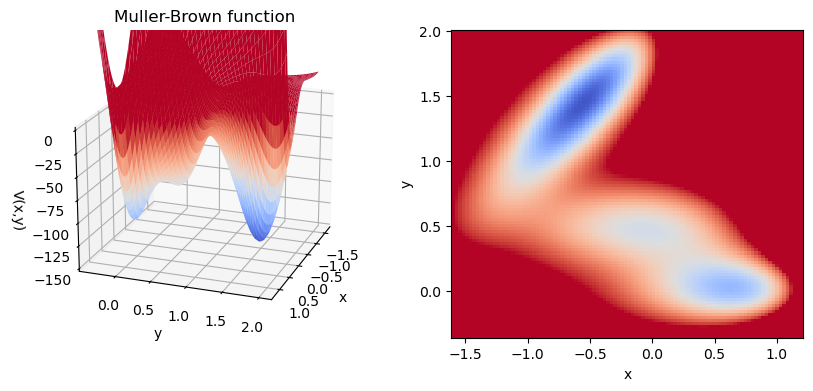

In [4]:
loss = MullerBrown()
# x and y domains for the plots
x_domain = [-1.6, 1.2] 
y_domain = [-0.35, 2] 
loss_min_max = [-150, 0] # bounds on values of the loss for plots 

gridx = np.linspace(x_domain[0], x_domain[1], 100)
gridy = np.linspace(y_domain[0], y_domain[1], 100)
x_plot = np.outer(gridx, np.ones(100)) 
y_plot = np.outer(gridy, np.ones(100)).T 
x2d = np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1)
loss_on_grid = loss.L(x2d).reshape(100,100)

fig = plt.figure(figsize=(10,4))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)
ax0.set_title("Muller-Brown function")
#--- to fix angles // in colab, otherwise in notebook could rotate using the mouse/touchpad ---
ax0.view_init(elev=20, azim=20) # play on the angles here to change the visualization
ax0.plot_surface(x_plot, y_plot, loss_on_grid ,vmin=loss_min_max[0], vmax=loss_min_max[1], cmap='coolwarm', edgecolor='none')
ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_zlabel("V(x,y)")
ax0.set_zbound(loss_min_max[0], loss_min_max[1])
ax1.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
plt.show()

**Question 1.** What are the maximum and minimum values on the loss on this grid?

In [5]:
print ( "Minimum and maximum values of the loss: (%.4f, %.4f)" % (loss_on_grid.min(), loss_on_grid.max()) )

Minimum and maximum values of the loss: (-146.6106, 3347.7689)


### Simple gradient method

We start by running a simple gradient method as
$$
X^{n+1} = X^n - \eta \nabla L(X^n)
$$
This functions takes as argument a potential object, an initial condition, the number of simulation steps and a time step. It possibly records the value of the potential energy function at the points along the trajectory.initial

In [6]:
def SimpleGradient(loss, X_0, eta=1e-3, Nepochs=1000, seed=None):
    """Performs a simple gradient dynamics 

    :param loss: must have methods for evaluation of the loss and its gradient 
    :param X_0: initial position, must be a 2D vector
    :param eta: learning rate
    :param Nepochs: number of iterations 
   
    :return: traj and loss_values, which are both np.array
    """
    dim = X_0.shape[0]
    X = X_0.reshape(1,dim)
    traj = []
    loss_values = []
    for i in range(Nepochs):
        X = X - eta*loss.nabla_L(X.reshape(1,dim))
        traj.append(X.reshape(dim,))
        loss_values.append(loss.L(X))
            
    return np.array(traj), np.array(loss_values)

**Question 2.** Play with the learning rate $\eta$ to find a good value (large enough in order for the convergence not to be too slow, but not too large in order to prevent oscillations/non convergence). Check also what happens when starting from $X^0 =(0,0)$ instead of $X^0 = (-1,0.5)$.

Timesteps are $10^{-4}$ lead to the fastest convergence. For smaller timesteps, the dynamics nicely converges but takes a long time to do so. For larger timesteps, oscillations are observed, the gradient dynamics does not converge.

For the initial condition (0,0), the dynamics gets stuck in a local minimum.

In [7]:
eta = 0.00002
Nepochs = 1000
seed = None 
x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]
trajectory, loss_values = SimpleGradient(loss,x_0,eta,Nepochs,seed)

The trajectory can then be plotted over the loss landscape, to check whether it converges to some local minimum. The values of the loss function should also be monitored.

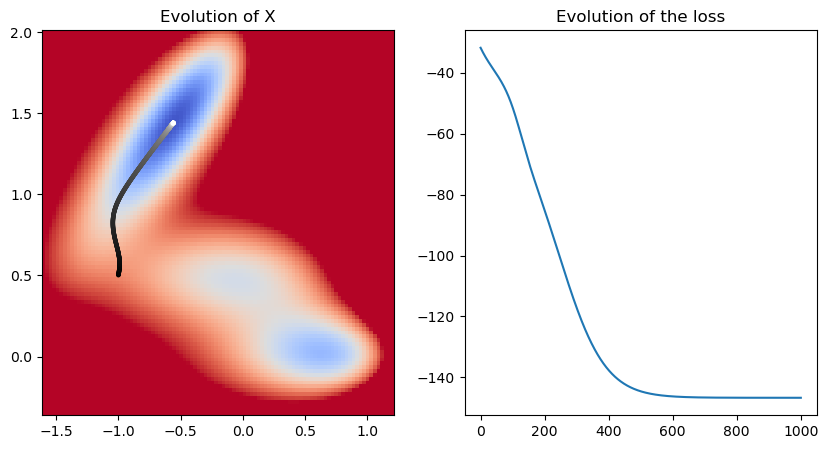

In [8]:
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of X')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(np.linspace(0,len(loss_values),len(loss_values)),loss_values)
ax1.set_title('Evolution of the loss')
plt.show()

### Stochastic gradient dynamics

We now consider the situation when the gradient is not exactly computed, but we have an unbiased stochastic estimator of it. In order to emulate SGD, we add a random component to the force, with average 0. This leads to the dynamics
$$
X^{n+1} = X^n + \eta \left( -\nabla L(X^n) + \sigma G^n\right).
$$
The magnitude $\sigma$ is fixed here, but it depends in practical situations on the minibatching size.

In [9]:
def SGD(loss, X_0, eta, Nepochs, sigma, seed=None):
    """Performs stochastic gradient dynamics in an ideal setting 

    :param loss: must have methods for evaluation of the loss and its gradient 
    :param X_0: initial position, must be a 2D vector
    :param eta: learning rate
    :param Nepochs: number of iterations 
    :param sigma: magnitude of the minibatching noise
   
    :return: traj and loss_values, which are both np.array
    """
    r = np.random.RandomState(seed)
    dim = X_0.shape[0]
    X = X_0.reshape(1,dim)
    traj = []
    loss_values = []
    for i in range(Nepochs):
        force = -loss.nabla_L(X.reshape(1,dim)) + sigma*r.normal(size=(dim,))
        X = X + eta*force
        traj.append(X.reshape(dim,))
        loss_values.append(loss.L(X))
            
    return np.array(traj), np.array(loss_values)

**Question 3.** Compare the behavior of SGD to simple gradient dynamics depending on the magnitude of $\sigma$. 

Note first that the dynamics gets sometimes stuck in a local minimum for certain realizations. For large noise, the minimization cannot be performed correctly unless the timestep is drastically reduced; essentially $\sigma\eta$ needs to be small. In this regime, SGD is similar to GD. When $\sigma\eta$ is of order 1, SGD remains in a vicinity of a local minimum, but rather samples values around this local minimum instead of performing some optimization. 

In [10]:
eta = 0.00002
sigma = 200
Nepochs = 1000
seed = None 
x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]
trajectory, loss_values = SGD(loss,x_0,eta,Nepochs,sigma,seed)

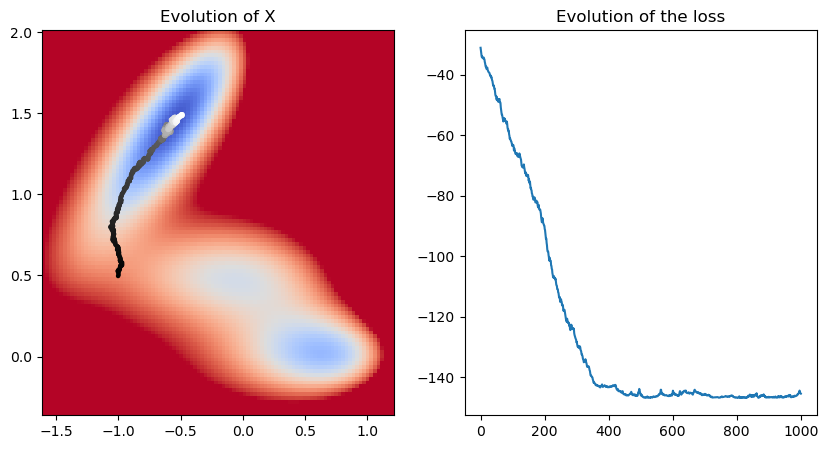

In [11]:
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of X')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(np.linspace(0,len(loss_values),len(loss_values)),loss_values)
ax1.set_title('Evolution of the loss')
plt.show()

## Nesterov accelerated gradient

Using some inertia in the minimization procedure may be beneficial. Here, this means adding a momentum variable $V$ to the position variable $X$.

**Question 4.** Implement the Nesterov accelerated gradient method seen in class, and find a relevant value of $\beta$. 

In [12]:
def Nesterov(loss, X_0, eta, beta, Nepochs, sigma, seed=None):
    """Performs Nesterov gradient descent in an ideal minibatching setting 

    :param loss: must have methods for evaluation of the loss and its gradient 
    :param X_0: initial position, must be a 2D vector
    :param V_0: initial momentum
    :param eta: learning rate
    :param beta: refreshment parameter
    :param Nepochs: number of iterations 
    :param sigma: magnitude of the minibatching noise
   
    :return: traj and loss_values, which are both np.array
    """
    r = np.random.RandomState(seed)
    dim = X_0.shape[0]
    X = X_0.reshape(1,dim)
    V = np.zeros((1,dim))
    traj = []
    loss_values = []
    for i in range(Nepochs):
        #--- Nesterov accelerated gradient ---
        Y = X + beta*V
        force = -loss.nabla_L(Y.reshape(1,dim)) + sigma*r.normal(size=(dim,))
        V = beta*V + eta*force
        X = X + V
        traj.append(X.reshape(dim,))
        loss_values.append(loss.L(X))
            
    return np.array(traj), np.array(loss_values)

We can then run the dynamics.

In [13]:
eta = 0.00002
beta = 0.3
sigma = 200
Nepochs = 300
seed = None 
x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]
trajectory, loss_values = Nesterov(loss,x_0,eta,beta,Nepochs,sigma,seed)

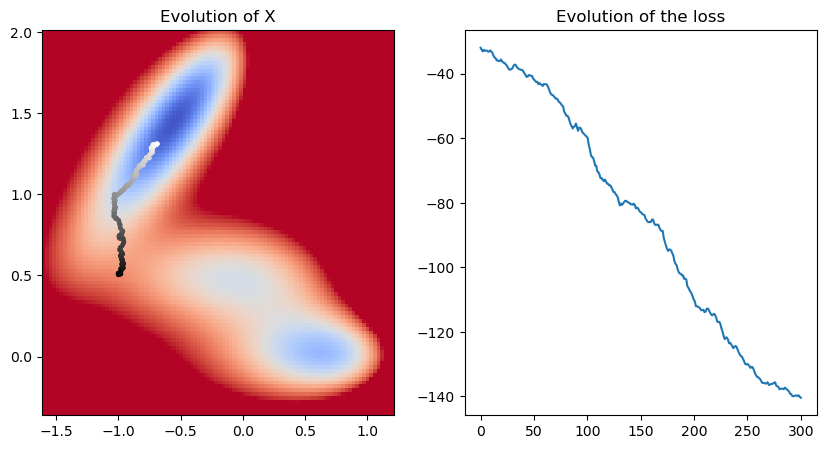

In [14]:
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of X')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(np.linspace(0,len(loss_values),len(loss_values)),loss_values)
ax1.set_title('Evolution of the loss')
plt.show()

### ADAM

We next consider the Adam algorithm presented in https://arxiv.org/abs/1412.6980.

**Question 5.** Implement the Adam method, and run it with the default suggested parameters $\beta_1,\beta_2$. How does the method compare to SGD?

In [15]:
def Adam(loss, X_0, eta, beta1, beta2, Nepochs, sigma, eps, seed=None):
    """Performs Adam in an ideal setting 

    :param loss: must have methods for evaluation of the loss and its gradient 
    :param X_0: initial position, must be a 2D vector
    :param eta: learning rate
    :param Nepochs: number of iterations 
    :param sigma: magnitude of the minibatching noise
   
    :return: traj and loss_values, which are both np.array
    """
    r = np.random.RandomState(seed)
    dim = X_0.shape[0]
    X = X_0.reshape(1,dim)
    v = np.zeros((1,dim))
    s = np.zeros((1,dim))
    traj = []
    loss_values = []
    for i in range(Nepochs):
        force = -loss.nabla_L(X.reshape(1,dim)) + sigma*r.normal(size=(dim,))
        v = beta1*v + (1-beta1)*force
        s = beta2*s + (1-beta2)*force**2
        vh = v/(1-beta1**(i+1))
        sh = s/(1-beta2**(i+1))
        X = X + eta*vh*(np.sqrt(sh)+eps)**(-1)
        traj.append(X.reshape(dim,))
        loss_values.append(loss.L(X))
            
    return np.array(traj), np.array(loss_values)

We can then run the dynamics.

In [16]:
eta = 0.01
beta1 = 0.9
beta2 = 0.999
eps = 10**(-6)
sigma = 2000
Nepochs = 2000
seed = None 
x_0 = np.array([-1,0.5]) # initial condition; check also with [0.,0.]
trajectory, loss_values = Adam(loss,x_0,eta,beta1,beta2,Nepochs,sigma,eps,seed)

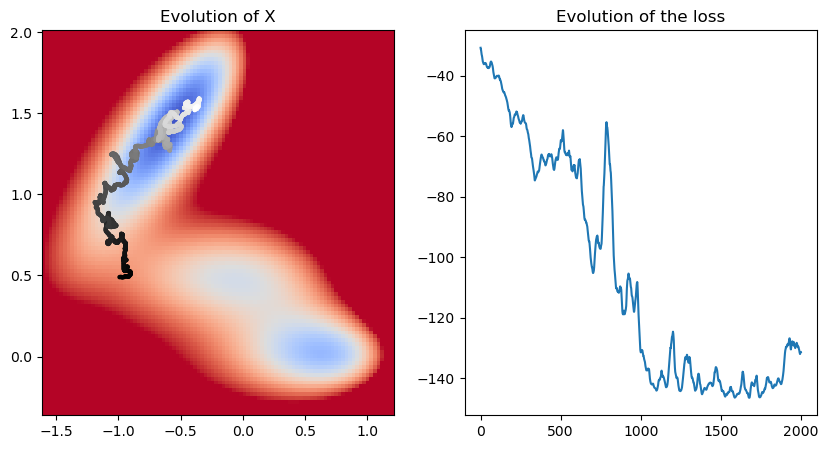

In [17]:
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
colors = np.round(np.linspace(0,100,len(trajectory)))
ax0.pcolormesh(x_plot,y_plot,loss_on_grid,cmap='coolwarm',shading='auto',vmin=loss_min_max[0],vmax=loss_min_max[1])
ax0.scatter(trajectory[:,0], trajectory[:,1],s=5,c=colors,cmap='gray')
ax0.set_title('Evolution of X')
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(np.linspace(0,len(loss_values),len(loss_values)),loss_values)
ax1.set_title('Evolution of the loss')
plt.show()